In [1]:
import json
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale
import slugify

# math packages:
import pandas as pd
import numpy as np
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# images and display
from IPython.display import Markdown as md
from IPython import display

# Plastock - Iqaasl

In [2]:
plastock = pd.read_csv("data/20230314macro.csv", sep=";", encoding="ISO-8859-3")
iqaasl = pd.read_csv("data/lac_leman_iqaasl.csv")
p_beaches = pd.read_csv("data/asl_beaches2.csv")

In [3]:
# the location names in asl_beaches does not match the names in 20230314macro.csv
# the names in the asl_beaches file were changed previously
# they need to be changed back to match the new survey data
p_names = sorted(p_beaches.location.unique())
pstock_names = sorted(plastock.Lieu.unique())

# the differences are capitalizations and hyphenations
renames = {x: p_names[i] for i, x in enumerate(pstock_names)}

plastock["Lieu"] = plastock.Lieu.apply(lambda x: renames[x])
p_names = sorted(p_beaches.location.unique())
pstock_names = sorted(plastock.Lieu.unique())

# the length needs to be added to the survey data
# make a map name => beach length from p_beaches
name_map = p_beaches.drop_duplicates("location")
name_map = name_map.set_index("location")
name_map = name_map["length"]
# the length of a beach
name_map.loc["Port Choiseul"]

# apply map to the survey data
plastock["Length"] = plastock.Lieu.map(lambda x: name_map.loc[x])

# we are only interested in certain columns
cols = ['Lieu', 'Date', 'Code', 'Quantité', "Length", 'Temps', 'Position', 'Substrat',  'Saison',  'Objet']
plastock = plastock[cols].copy()

# we need a loc_date (unique survey id) column and set the date to iso
plastock["loc_date"] = list(zip(plastock["Lieu"], plastock["Date"]))
plastock["loc_date"] = plastock.loc_date.astype(str)

# convert to datetime
plastock["date"] = pd.to_datetime(plastock["Date"], format="%d.%m.%Y").dt.date

# we only need certain columns from the iqaasl data
work_columns = ['location', 'loc_date', 'date', 'code', 'pcs_m', 'quantity']
iqaasl = iqaasl[work_columns]
iqaasl["project"] = "iqaasl"

# we need to convert quantity to pcs/m in the plastock data
plastock['pcs_m'] = plastock["Quantité"]/plastock.Length

# the column names in the plastock data and iqaasl data need to be the same
renames = {"Lieu":"location", "Code":"code", "Quantité":"quantity"}
pstock = plastock.rename(columns=renames)
pstock = pstock[work_columns]
pstock["project"] = "plastock"

In [4]:
# there are aggregations that need to be made to the plastock data. The fragemented foams
# and fragmented plastics are consolidated into one group of codes. The plastic caps are consolidated
# as per the intend of the ASL and the recomendation from the IQAASL report.    
gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
columns = ['loc_date', 'location', 'date', 'project']
operations = {"quantity":"sum", "pcs_m": "sum"}

# separate the codes of interest by group from the data frame and add the replacement value
pstock_gfrags = pstock[pstock.code.isin(plasticpcs)].groupby(columns, as_index=False).agg(operations)
pstock_gfoam = pstock[pstock.code.isin(gfoam)].groupby(columns, as_index=False).agg(operations)
pstock_gcaps = pstock[pstock.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)

pstock_gcaps["code"] = "Gcaps"
pstock_gfoam["code"] = "Gfoam"
pstock_gfrags["code"] = "Gfrags"

# remove the same instances from the work data                                                               
pstock_no_frags = pstock[~pstock.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# combine with 
pstock = pd.concat([pstock_no_frags, pstock_gfrags, pstock_gfoam, pstock_gcaps])

# make gcaps, gfrags and foams are ready made
iqaasl_not_caps = iqaasl[~iqaasl.code.isin(Gcaps)].copy()
iqaasl_caps = iqaasl[iqaasl.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)
iqaasl_caps["code"] = "Gcaps"

iqaasl = pd.concat([iqaasl_caps, iqaasl_not_caps])

combined = pd.concat([pstock, iqaasl])

# we are only using the valid codes from plastock
codes = pstock.code.unique()
workdata = combined[combined.code.isin(codes)]

# check the aggregations
cgfrags = combined[(combined.project == "plastock")&(combined.code == "Gfrags")].quantity.sum()
gfrag_isolated = pstock_gfrags.quantity.sum()
pstock_gfrags = pstock[pstock.code == "Gfrags"].quantity.sum()

## scatter plot by date

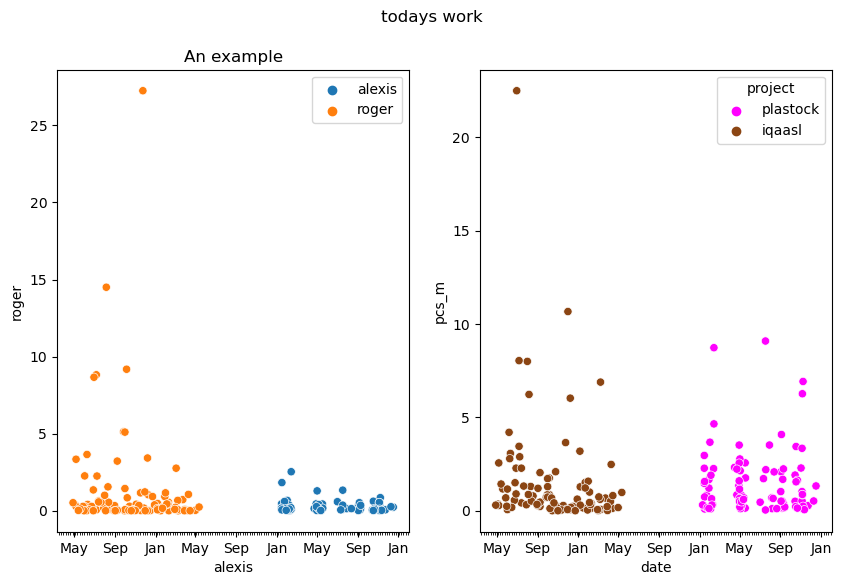

In [5]:
# we need to aggregate by sample
# axis notations
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

code = "Gfoam"
daily_totals = workdata[workdata.code == code].groupby(["loc_date", "date", "project"], as_index=False).pcs_m.sum()
daily_totalss = workdata[workdata.code == "Gfrags"].groupby(["loc_date", "date", "project"], as_index=False).pcs_m.sum()
fig, ax = plt.subplots(1,2, figsize=(10, 6))

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", ax=ax[0], hue="project")
sns.scatterplot(data=daily_totalss, x="date", y="pcs_m", ax=ax[1], hue="project", palette= {"iqaasl":"saddlebrown", "plastock":"magenta"})

# format ticks and locations
ax[0].xaxis.set_minor_locator(days)
ax[0].xaxis.set_major_formatter(months_fmt)

h, l = ax[0].get_legend_handles_labels()
ax[1].xaxis.set_minor_locator(days)
ax[1].xaxis.set_major_formatter(months_fmt)


labels = ["alexis", "roger"]

ax[0].legend(h, labels)

ax[0].set_xlabel("alexis")
ax[0].set_ylabel("roger")
ax[0].set_title("An example")
plt.suptitle("todays work")

plt.savefig("example.jpeg", dpi=300)
plt.show()

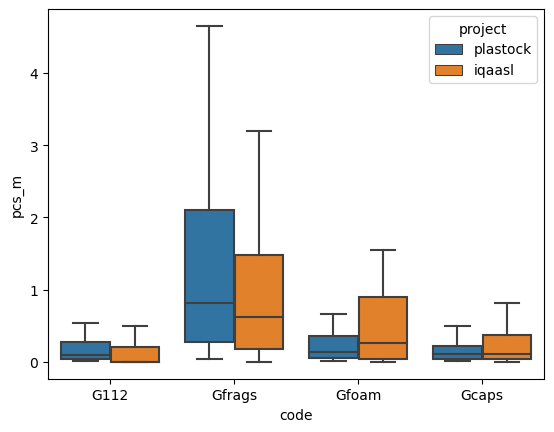

In [6]:
# compare code values
# choose a code
codes = ["G112", "Gcaps", "Gfoam", "Gfrags"]

fig, ax = plt.subplots()

sns.boxplot(data=workdata[workdata.code.isin(codes)], x="code", y="pcs_m", ax=ax, hue="project", showfliers=False)

plt.show()

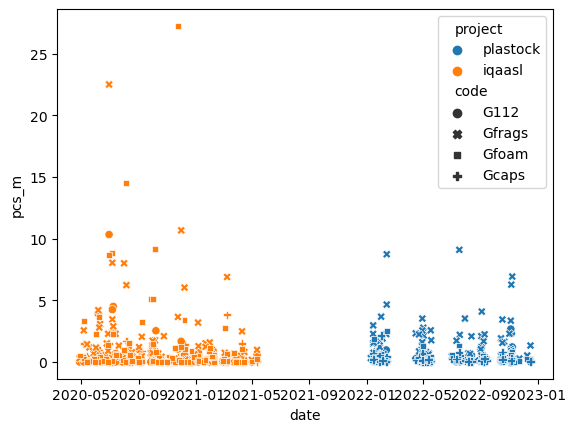

In [7]:
# we need to aggregate by sample
daily_totals = workdata[workdata.code.isin(codes)]

fig, ax = plt.subplots()

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", ax=ax, hue="project", style="code")


plt.show()

In [8]:
summary = daily_totals.groupby(["project", "code"]).pcs_m.describe()
summary.index.names = (None, None)

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]

summary.style.set_table_styles(table_css_styles)